<a href="https://colab.research.google.com/github/pyagoubi/Motorcycle-data/blob/main/Motorcycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%%capture
pip install geopandas

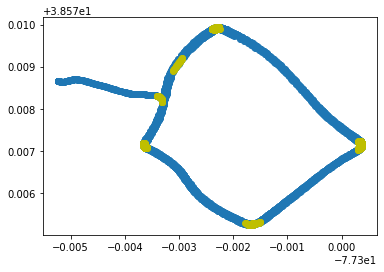

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import geopandas
import geopy.distance

data = pd.read_csv('/content/drive/MyDrive/upwork1/DATA1.TXT', sep=',')
data['Gx clean'] = data['Gx']-data['Gx Cal']
data['Gy clean'] = data['Gy']-data['Gy Cal']


#Parameters

shift_a = 30
degree_min = 50
min_samples = 50
cluster_area = 0.02


def angle_corner(df, shift_parameter = shift_a, degree_pm = degree_min):

  df['degrees'] = 0
  df['corner_a'] = 0

  for i in df['SessionID'].unique():
    
    
    data = df[df['SessionID'] == i]

    # Convert the points to numpy latitude/longitude radians space

    data['Lat converted'] = np.radians(data['Latitude'])
    data['Lon converted'] = np.radians(data['Longitude'])

    #past reference point
    data['Lat before'] = data['Lat converted'].shift(shift_parameter)
    data['Lon before'] = data['Lon converted'].shift(shift_parameter)

    #future reference point
    data['Lat after'] = data['Lat converted'].shift(-shift_parameter)
    data['Lon after'] = data['Lon converted'].shift(-shift_parameter)


    # Vectors in latitude/longitude space
    data['vector prev'] = (np.array(data[['Lat converted', 'Lon converted']]) - np.array(data[['Lat before', 'Lon before']])).tolist()
    data['vector past'] = (np.array(data[['Lat converted', 'Lon converted']]) - np.array(data[['Lat after', 'Lon after']])).tolist()


    for j in range(len(data)):
      if np.isnan(data['vector prev'][j][0]) == False:
        data.iloc[j, data.columns.get_loc('degrees')] = np.degrees(math.acos(np.dot(data['vector prev'][j], data['vector past'][j]) / (np.linalg.norm(data['vector prev'][j]) * np.linalg.norm(data['vector past'][j]) +1e-20)))
        #print(data.iloc[i, data.columns.get_loc('degrees')])
    
    data.loc[(data['degrees'] < (180 - degree_pm) )  |  (data['degrees'] > (180 + degree_pm) )    , 'corner_a'] = 1

    df.loc[df['SessionID'] == i, 'corner_a'] = data['corner_a']
    df.loc[df['SessionID'] == i, 'degrees'] = data['degrees'] 


  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['corner_a'] == 1), 'Longitude'], y=df.loc[(df['corner_a'] == 1),'Latitude'], color = 'y')  

  return df

data = angle_corner(data, shift_parameter = shift_a, degree_pm = degree_min)

# Identifying true corners with DBSCAN


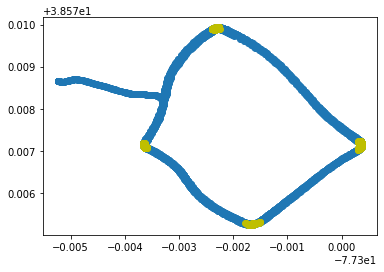

In [95]:
def true_corners(df, min_samples=min_samples, cluster_area = cluster_area):
  
  coords = df.loc[df['corner_a']==1, ['Longitude', 'Latitude']]
  db = DBSCAN(eps=cluster_area/6371., min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(df.loc[df['corner_a']==1, ['Longitude', 'Latitude']]))

  cluster_labels = db.labels_

  df['Corner Number'] = -1
  num_clusters = len(set(cluster_labels))
  clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

  df.loc[df['corner_a']==1, 'Corner Number'] = cluster_labels

  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['Corner Number'] >= 0), 'Longitude'], y=df.loc[(df['Corner Number'] >= 0),'Latitude'], color = 'y') 

  return df

data = true_corners(data)


# Determine Reference points 

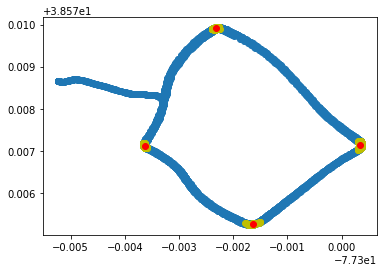

In [96]:
def centroids(df):

  corners_df = pd.DataFrame()

  centroid_x = []
  centroid_y = []

  corners = df['Corner Number'].unique().tolist()
  corners.remove(-1)

  for corner in corners:
    point = MultiPoint(geopandas.points_from_xy(df.loc[df['Corner Number'] == corner,'Longitude'], df.loc[df['Corner Number'] == corner, 'Latitude'] , crs="EPSG:4326" ))
    centroid_x.append(point.centroid.x)
    centroid_y.append(point.centroid.y)
    del point
  
  corners_df['Corner Nr'] = corners
  corners_df['Longitude'] = centroid_x
  corners_df['Latitude'] = centroid_y

  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['Corner Number'] >= 0), 'Longitude'], y=df.loc[(df['Corner Number'] >= 0),'Latitude'], color = 'y') 
  plt.scatter(x=corners_df['Longitude'], y=corners_df['Latitude'], color = 'r')

  return corners_df

reference_points = centroids(data)



# Average Breaking Distance

#Determine Breaking Points

Breaking points are considered local speed minima within a range of *proximity* meters within a corner reference point. Ths is considered the endpoint of the breaking and starting point of acceleration.

In [ ]:
# Calculate distances between reference points and track

def distances(df, maxcorner):

  dfrrr
  for i in range(maxcorner):
    corner_lon = reference_points.loc[reference_points['Corner Nr']== i , 'Longitude'].values[0]
    corner_lat = reference_points.loc[reference_points['Corner Nr']== i , 'Latitude'].values[0]
    ref = (corner_lat,corner_lon)
    print(ref)
    for j in range(len(data)):
      dist = geopy.distance.geodesic(ref, coordinates[j]).m   
      distances.append(dist)
    data[f'Distance from corner {i}'] = distances
    distances=[]
       

In [23]:
maxcorner = reference_points['Corner Nr'].max()

data = ''

In [28]:
distances = []
coordinates = list(zip(data['Latitude'], data['Longitude']))

In [39]:
reference_points.loc[reference_points['Corner Nr']== 0 , 'Longitude'].values[0]

-77.30232493027779

In [111]:


for i in range(maxcorner):
  corner_lon = reference_points.loc[reference_points['Corner Nr']== i , 'Longitude'].values[0]
  corner_lat = reference_points.loc[reference_points['Corner Nr']== i , 'Latitude'].values[0]
  ref = (corner_lat,corner_lon)
  print(ref)
  for j in range(len(data)):
    dist = geopy.distance.geodesic(ref, coordinates[j]).m   
    distances.append(dist)
  data[f'Distance from corner {i}'] = distances
  distances=[]
       


(38.57991059574999, -77.30232493027779)
(38.57713672238293, -77.29965350598583)
(38.57526129434373, -77.30163490724998)


In [120]:
data['distance_factor'] = 0


minids = data.groupby('Lap Number')['Distance from corner 0'].apply(lambda x: x.idxmin())









In [124]:
minids[1]

131

In [132]:
del data['tmpindex'] 

In [136]:
data.loc[(data.index <= minids[2])  & (data['Lap Number'] == 2) ,'Distance from corner 0'] *= -1

In [135]:
data['Distance from corner 0']

0      -131.011931
1      -130.289803
2      -129.220102
3      -127.429202
4      -126.349888
           ...    
4197    289.686276
4198    289.686276
4199    289.686276
4200    289.686276
4201    289.686276
Name: Distance from corner 0, Length: 4202, dtype: float64

In [ ]:
data['Distance from corner 0'] = data.groupby('Lap Number')['Distance from corner 0'].transform(lambda x: x[x['Distance from Corner 0'] ==x['Distance from Corner 0'].min()   * -1)

In [107]:
data.loc[data['Lap Number'] == 2 , 'Distance from corner 0']

813    -130.278114
814    -129.214271
815    -127.787551
816    -125.302531
817    -123.876928
           ...    
1475   -139.981624
1476   -136.754836
1477   -134.960476
1478   -133.166660
1479   -131.720195
Name: Distance from corner 0, Length: 667, dtype: float64

In [ ]:
data['Distance from corner 0']

In [41]:
import seaborn as sns

<AxesSubplot:xlabel='Distance from corner 0', ylabel='Speed'>

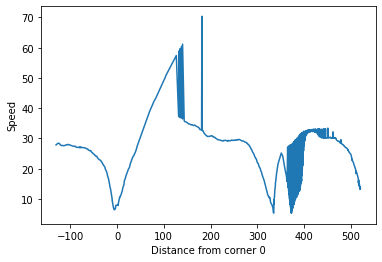

In [139]:
sns.lineplot(data=data[data['Lap Number']==2], x='Distance from corner 0', y='Speed')

In [16]:
temp=[1,2,34]
temp=[]
temp

[]

In [ ]:
data[data['Lap Number']==1].iloc[data['Distance from corner 0'].idxmin()+1:, data.columns.get_loc('Distance from corner 0')] =data[data['Lap Number']==1].iloc[data['Distance from corner 0'].idxmin()+1:, data.columns.get_loc('Distance from corner 0')] *-1

In [98]:
data['Distance from corner 0']

0       131.011931
1       130.289803
2       129.220102
3       127.429202
4       126.349888
           ...    
4197    289.686276
4198    289.686276
4199    289.686276
4200    289.686276
4201    289.686276
Name: Distance from corner 0, Length: 4202, dtype: float64

In [78]:
data.iloc[data['Distance from corner 0'].idxmin() :, data.columns.get_loc('Distance from corner 0')]

131       0.447020
132       0.841316
133       1.201815
134       1.880580
135       2.270951
           ...    
4197    289.686276
4198    289.686276
4199    289.686276
4200    289.686276
4201    289.686276
Name: Distance from corner 0, Length: 4071, dtype: float64

In [91]:

data['Distance from corner 0'] = data.groupby('Lap Number')['Distance from corner 0'].transform(lambda x: x[:x.idxmin()]* -1)





In [93]:
data

0      -131.011931
1      -130.289803
2      -129.220102
3      -127.429202
4      -126.349888
           ...    
4197   -289.686276
4198   -289.686276
4199   -289.686276
4200   -289.686276
4201   -289.686276
Name: Distance from corner 0, Length: 4202, dtype: float64

In [52]:
data.iloc[data[data['Distance from corner 0'] ==data['Distance from corner 0'].min()].index :, 'Distance from corner 0']

ValueError: ignored

In [8]:
maxcorner= reference_points['Corner Nr'].max()

In [13]:
temp = pd.DataFrame()
temp[[f'DIstance from corner {i}' for i in range(maxcorner)] ] =0
temp

,DIstance from corner 0,DIstance from corner 1,DIstance from corner 2


In [ ]:
reference_points['Corner Nr']

df = df.assign(col_name=[f'DIstance from corner {}'    ])

In [ ]:
data['distance'] = 0

In [ ]:
data['distance'].groupby('Lap Number').apply()

In [ ]:
a = zip(data['Latitude'], data['Longitude'])

a = list(a)
t = []
te = []
for i in range(1, len(a)):
 t.append(geopy.distance.geodesic(a[i], a[i-1]).m)
 te.append(geopy.distance.geodesic(a[i], a[i-1]).km)

t

In [ ]:
te

[0.0008468759072224651,
 0.0010767657842651085,
 0.0018195375633309138,
 0.0012703693700497117,
 0.002153390021468709,
 0.0018196407675056072,
 0.002219181042225713,
 0.0012704803913798632,
 0.0007881455577282983,
 0.0025002223484259928,
 0.0014337917467953452,
 0.0008468759262294629,
 0.001076765018916664,
 0.001270369396923364,
 0.001076623790925417,
 0.000846986938437194,
 0.001076623705296905,
 0.0014338319021906013,
 0.0010766235983503932,
 0.001076710876838455,
 0.0012703694105386486,
 0.0008468759382479439,
 0.0010767645300008278,
 0.0010766233645532178,
 0.0012703694176231252,
 0.0021533875957389873,
 0.0014337911424158955,
 0.001693862903206031,
 0.0010766768290285114,
 0.003572713732709417,
 0.0012703694359998234,
 0.0010767100884013447,
 0.0018195683493475248,
 0.0012703694434391454,
 0.0007882030416434869,
 0.0014338310919904988,
 0.0010767098126719598,
 0.0010766224496174049,
 0.0012703694542564,
 0.0008469869746403745,
 0.0010766761063151257,
 0.0010766222566886104,
 0.00